# Mapping potential GDV by clustering wet and dry period NDVI and NDMI layers
Author: Michael A. Short <br>
Date: Febraury 2020 <br>

This is a notebook to perform a cluster analysis on wet and dry period normalised difference vegetation index (NDVI) and moisture index (NDMI) derived from Landsat or Sentinel data to identify potentially groundwater dependent vegetation (GDV). The method is based on the paper by Barron et al. (2014) ('Mapping groundwater-dependent ecosystems using remote sensing measures of vegetation and moisture dynamics', _Hydrological Processes_ __28__: 372-385 https://onlinelibrary.wiley.com/doi/pdf/10.1002/hyp.9609).<br>
The `scikit-learn` and `yellowbrick` packages are non-standard. To install them use something like the following (depends if you're using Anaconda as your Python distribution: <br>
`conda install -c anaconda scikit-learn` and;
`conda install -c districtdatalabs yellowbrick`

### 1. Import Python functions

In [1]:
# import required packages
import pandas as pd
import os
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mich1\AppData\Local\Continuum\anaconda3\envs\ThreePointSeven\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Set your directory
Set your working directory if it's different to where you've opened this notebook. If it's the same, skip this step.

In [7]:
print("Original working directory:" , os.getcwd()) # prints the starting working directory
os.chdir("C:/Users/mich1/Documents/Python Scripts/NDVI_NDMI_clustering") # changes the working directory (if needed)
#os.chdir("/Users/michaelshort/Documents/Python Scripts") #MacBook location
print("...New working directory:" , os.getcwd()) # prints the new working directory (if changed)

Original working directory: C:\Users\mich1\Documents\Python Scripts\NDVI_NDMI_clustering
...New working directory: C:\Users\mich1\Documents\Python Scripts\NDVI_NDMI_clustering


### 3. Setting some variables
This block sets up some variables used later in the notebook - namely the prefix for your study area (e.g. 'Bon' for Bonaparte Plains) and the number of clusters you are going to use (this can be chosen blind or informed by __Step 6a. Run the Elbow method__ or __Step 6b. Run the Silhouette method__).

In [50]:
area_prefix = 'Bon' # A prefix used for the study area in the output file names
n_clusters = 7 # Number of clusters chosen for the analysis (also used in file naming)

### 4. Specify input file names
This block specifies the file names and location for the input data. The csv files can either be one with all vegetation/moisture index pixel values or (as is currently the case) four separate files. At least one file should have the corresponding pixel coordinates. The csv columns can either be with or without column headers but the current script is for no headers - you will need to modify the script if your do have headers.

In [11]:
WetNDVI_file = "data/wet_NDVI.csv"
WetNDMI_file = "data/wet_NDMI.csv"
DryNDVI_file = "data/dry_NDVI.csv"
DryNDMI_file = "data/dry_NDMI.csv"

### 5. Load input files
This block loads the input files, removes nodata values (e.g. -999) and replaces them with NaNs, and then adds the data to one dataframe with the columns `Easting`, `Northing`, `WetNDVI`, `DryNDVI`, `WetNDMI` and `DryNDMI`.<br>
_Times are tracked here to give you an idea of how long things are taking._

In [14]:
# Load Wet NDVI data
st = datetime.now() # grabs time before .csv loading begins
print("Wet NDVI import started at:" , st) #prints time before process begins
WetNDVI = pd.read_csv(WetNDVI_file, sep=",", names=["Easting","Northing","WetNDVI"]) # reads .csv as a pandas dataframe and applies column names
WetNDVI = WetNDVI.replace(-999.0, np.nan) # replaces all -999 values to NaNs. Change if your file has no-data stored as something else
print("...Time taken to load Wet NDVI:" , datetime.now() - st) # prints the time taken to load the .csv file
# Load Wet NDMI data
st = datetime.now()
print("Wet NDMI import started at:" , st)
WetNDMI = pd.read_csv(WetNDMI_file, sep=",", names=["Easting","Northing","WetNDMI"])
WetNDMI = WetNDMI.replace(-999.0, np.nan)
print("...Time taken to load Wet NDMI:" , datetime.now() - st)
# Load Dry NDVI data
st = datetime.now()
print("Dry NDVI import started at:" , st)
DryNDVI = pd.read_csv(DryNDVI_file, sep=",", names=["Easting","Northing","DryNDVI"])
DryNDVI = DryNDVI.replace(-999.0, np.nan)
print("...Time taken to load Dry NDVI:" , datetime.now() - st)
# Load Dry NDMI data
st = datetime.now()
print("Dry NDMI import started at:" , st)
DryNDMI = pd.read_csv(DryNDMI_file, sep=",", names=["Easting","Northing","DryNDMI"])
DryNDMI = DryNDMI.replace(-999.0, np.nan)
print("...Time taken to load Dry NDMI:" , datetime.now() - st)

# Add Wet and Dry data to a dataframe
df = pd.concat([WetNDVI["Easting"],WetNDVI["Northing"],
                WetNDVI["WetNDVI"],DryNDVI["DryNDVI"],
                WetNDMI["WetNDMI"],DryNDMI["DryNDMI"]], axis=1) # makes a combined dataframe (named "df") with columns from the individual dataframes

# Removes NaNs for clustering because the function doesn't accept them
df = df.dropna() # removes rows with NaNs

Wet NDVI import started at: 2020-02-26 10:05:12.496139
...Time taken to load Wet NDVI: 0:00:01.782010
Wet NDMI import started at: 2020-02-26 10:05:14.278149
...Time taken to load Wet NDMI: 0:00:01.964747
Dry NDVI import started at: 2020-02-26 10:05:16.242896
...Time taken to load Dry NDVI: 0:00:01.921909
Dry NDMI import started at: 2020-02-26 10:05:18.164805
...Time taken to load Dry NDMI: 0:00:01.738707


### 6a. Run the Elbow method
This block runs the Elbow method. This is a cluster visualisation method to determine the optimal number of clusters to chose. The `yellowbrick` Elbow method function also gives a best guess of the optimal number (a vertical dashed black line). The plot is saved in the `outputs` folder.<br>
_Times are tracked here to give you an idea of how long things are taking._

Elbow method started at: 2020-02-26 12:39:35.458426


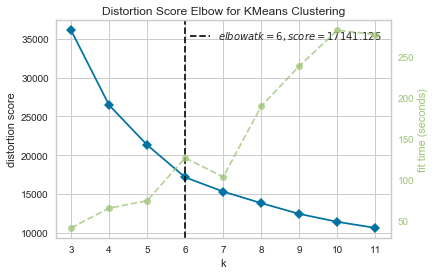

...Time taken to process Elbow method: 0:23:24.532634


In [44]:
st = datetime.now()
fig, ax = plt.subplots() # sets up the plot
print("Elbow method started at:" , st) # prints time before process begins
model = KMeans() # sets the cluster method
visualizer = KElbowVisualizer(model, k=((n_clusters - 3),(n_clusters + 6)), ax=ax) # Sets up the Elbow method parameters
visualizer.fit(df[["WetNDVI","DryNDVI","WetNDMI","DryNDMI"]]) # fits the Elbow method to the variables
visualizer.show() # shows the plot
fig.savefig(f"outputs/{area_prefix}_Elbow_plot.png") # saves the figure to the 'outputs' folder
plt.clf() # clears the figure
plt.cla() # clears the axes
plt.close() # closes the plot
print("...Time taken to process Elbow method:" , datetime.now() - st) # prints the time taken to run this block

### 6b. Run the Silhouette method (NOTE: this method takes a long time!)
This block runs an alternative to the Elbow method for determining the optimal number of clusters. However, it is much more computationally intensive, so look up on it and see if it's really needed. It's been included as another option, though.<br>
_Times are tracked here to give you an idea of how long things are taking._

In [7]:
st = datetime.now()
fig, ax = plt.subplots() # sets up the plot
print("Silhouette method started at:" , st) # prints time before process begins
model = KMeans(n_clusters=(n_clusters + 6)) # sets the cluster method
visualizer = SilhouetteVisualizer(model, colors='yellowbrick') # Sets up the Silhouette method parameters
visualizer.fit(df[["WetNDVI","DryNDVI","WetNDMI","DryNDMI"]]) # fits the Elbow method to the variables
visualizer.show() # shows the plot
plt.savefig(f"outputs/{area_prefix}_Silhouette_plot.png") # saves the figure to the 'outputs' folder
plt.clf() # clears the figure
plt.cla() # clears the axes
plt.close() # closes the plot
print("...Time taken to process Silhouette method:" , datetime.now() - st) # prints the time taken to run this block

### 7. Run the k-means cluster analysis
This block runs the k-means cluster analysis. There are other more advanced clustering methods in the `scikit-learn` package but they have very big memory trade-offs when running with very large datasets such as landsat pixels. Some of the other methods were tried but they took far too long to run (or didn't at all on an 8GB memory computer) and they didn't seem to produce better results to the k-means method anyway.<br>
_Times are tracked here to give you an idea of how long things are taking._

In [51]:
st = datetime.now() # grabs time before cluster analysis begins
print("Cluster analysis process started at:" , st) #prints time before process begins
kmeans = KMeans(n_clusters=n_clusters) # primes the cluster analysis with a specified number of groups
# performs kmeans cluster analysis using specified columns of df and adds the cluster number a s new column to df
df["Cluster"] = kmeans.fit_predict(df[["WetNDVI","DryNDVI","WetNDMI","DryNDMI"]])
# prints the time taken to perform cluster analysis
print("...Time taken to perform cluster analysis:" , datetime.now() - st)

Cluster analysis process started at: 2020-02-26 13:30:56.543458
...Time taken to perform cluster analysis: 0:02:21.560436


### 8. Write the cluster centroids to csv
This block writes the centroids of the clusters from the model above to a csv file.

In [79]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = ["WetNDVI", "DryNDVI", "WetNDMI", "DryNDMI"]
centroids["Cluster"] = pd.DataFrame(np.arange(1, n_clusters + 1))
centroids.to_csv(f"outputs/{area_prefix}_{n_clusters}_kmeans_centroids.csv")
print(centroids.shape)                     
print(centroids)

(7, 5)
    WetNDVI   DryNDVI   WetNDMI   DryNDMI  Cluster
0  0.499325  0.270703  0.029685 -0.149217        1
1 -0.049740 -0.062570  0.769710  0.601209        2
2  0.586651  0.470119  0.381121  0.254321        3
3  0.205683  0.161660  0.020942 -0.044309        4
4  0.556383  0.333682  0.082447 -0.085214        5
5  0.589116  0.270722  0.146984 -0.157922        6
6  0.130369  0.130578  0.331406  0.172170        7


### 9. Write the cluster results to csv
This block writes the results of the cluster analysis to a csv for making a GeoTIFF. <br>
_Times are tracked here to give you an idea of how long things are taking._

In [53]:
st = datetime.now() # grabs time before .csv writing begins
print("Results file writing started at:" , st) #prints time before process begins
df.to_csv(f"outputs/{area_prefix}_{n_clusters}_kmean_results.csv") # writes the dataframe to a .csv file
print("...Time taken to write results file:" , datetime.now() - st) # prints the time taken to write .csv

Results file writing started at: 2020-02-26 13:35:27.639657
...Time taken to write results file: 0:00:24.559033


### 10. Sample the results and plot by cluster
This block takes a random sample of the results (default is set to sample 10,000 points), writes them to a csv file for plotting elsewhere (if needed), and plots the results with the centroids.

Results sampling and writing started at: 2020-02-26 14:04:42.815593


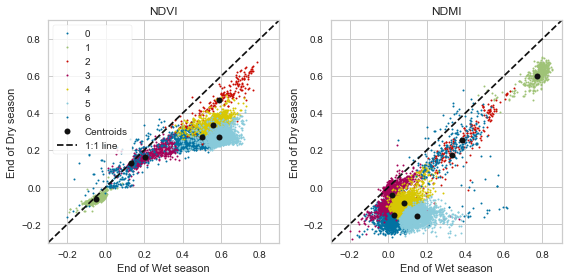

...Time taken plot: 0:00:01.393985


In [80]:
sample_10k = df.sample(n=10000) # gets a random sample (of size n) from the cluster results
samples_grouped = sample_10k.groupby('Cluster') # group the dataframe by cluster for plotting
min = -0.3 # min of plots
max = 0.9 # max of plots
fig = plt.figure() # sets up plot object
fig.set_size_inches(8,4) # sets the size in inches
ax1 = fig.add_subplot(121) # adds a subplot
ax2 = fig.add_subplot(122) #adds another subplot
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in samples_grouped: # plots the random sample by cluster
    ax1.plot(group.WetNDVI, group.DryNDVI, marker='o', 
             linestyle='', ms=2, label=name)
    ax2.plot(group.WetNDMI, group.DryNDMI, marker='o', 
             linestyle='', ms=2, label=name)
ax1.plot(centroids.WetNDVI, centroids.DryNDVI, marker='o', 
         color='k', linestyle='', ms=6, label='Centroids') # plots centroids
ax2.plot(centroids.WetNDMI, centroids.DryNDMI, marker='o', 
         color='k', linestyle='', ms=6)
ax1.plot([-1.,1.],[-1.,1.], marker='', linestyle='--', color = 'k', label='1:1 line') # plots a 1:1 line
ax2.plot([-1.,1.],[-1.,1.], marker='', linestyle='--', color = 'k')
ax1.title.set_text('NDVI') # adds plot titles
ax2.title.set_text('NDMI')
ax1.set_xlim(min, max) # sets axes limits
ax1.set_ylim(min, max)
ax2.set_xlim(min, max)
ax2.set_ylim(min, max)
ax1.set_xlabel('End of Wet season') # adds axes labels
ax1.set_ylabel('End of Dry season')
ax2.set_xlabel('End of Wet season')
ax2.set_ylabel('End of Dry season')
ax1.set_xticks([-.2,0.,.2,.4,.6,.8]) # sets axes increments
ax1.set_yticks([-.2,0.,.2,.4,.6,.8])
ax2.set_xticks([-.2,0.,.2,.4,.6,.8])
ax2.set_yticks([-.2,0.,.2,.4,.6,.8])
legend  = ax1.legend(frameon=True) # adds a legend and frames it
legend.get_frame().set_facecolor('w') # set a face colour for the legend box
fig.tight_layout() # makes the plots look better
plt.show()
fig.savefig(f"outputs/{area_prefix}_{n_clusters}_NDVIvNDMI.png") # saves the figure to the 'outputs' folder
plt.clf() # clears the figure
plt.cla() # clears the axes
plt.close() # closes the plot